In [28]:
# import the necessary python libraries needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [29]:
#parsing the data into a dataframe,i used .read_csv beacuse the dataset format is in a .csv
df=pd.read_csv('nigeria_agricultural_exports.csv')

In [30]:
#Displaying the first five rows of the dataframe
df.head()

,Product Name,Company,Export Country,Date,Units Sold,unit_price,Profit per unit,Export Value,Destination Port,Transportation Mode
0,Rubber,Farmgate Nigeria Limited,Austria,11/16/2023,721,31443.05,5863.92,22670439.05,Lagos,Sea
1,Palm Oil,Prime Agro Exports Nigeria Limited,Germany,1/8/2021,881,23151.97,5868.73,20396885.57,Lagos,Sea
2,Cassava,Farmgate Nigeria Limited,Germany,10/14/2020,702,18536.45,5105.01,13012587.90,Calabar,Sea
3,Rubber,Nigerian Export Promotion Council (NEPC),Belgium,12/31/2022,191,21981.31,7781.54,4198430.21,Warri,Sea
4,Sesame,Nigeria Agro Export Company,France,12/19/2022,373,13415.94,9590.95,5004145.62,Lagos,Sea


In [19]:
df['Date']=pd.to_datetime(df['Date'])
df['Year']=df["Date"].dt.year

#Group by product Name and Year
yearly_values = df.groupby(['Product Name', 'Year'])['Export Value'].sum().reset_index()

# Calculate percentage increase
results = []
for product, group in yearly_values.groupby('Product Name'):
    group = group.sort_values('Year')
    first_val = group['Export Value'].iloc[0]
    last_val = group['Export Value'].iloc[-1]
    if first_val != 0:  # avoid division by zero
        perc_increase = ((last_val - first_val) / first_val) * 100
        results.append((product, perc_increase))

# Create DataFrame from results
increase_df = pd.DataFrame(results, columns=['Product Name', 'Percentage Increase'])

# Find the max
top_product = increase_df.loc[increase_df['Percentage Increase'].idxmax()]
print(top_product)

Product Name               Cocoa
Percentage Increase    54.143319
Name: 2, dtype: object


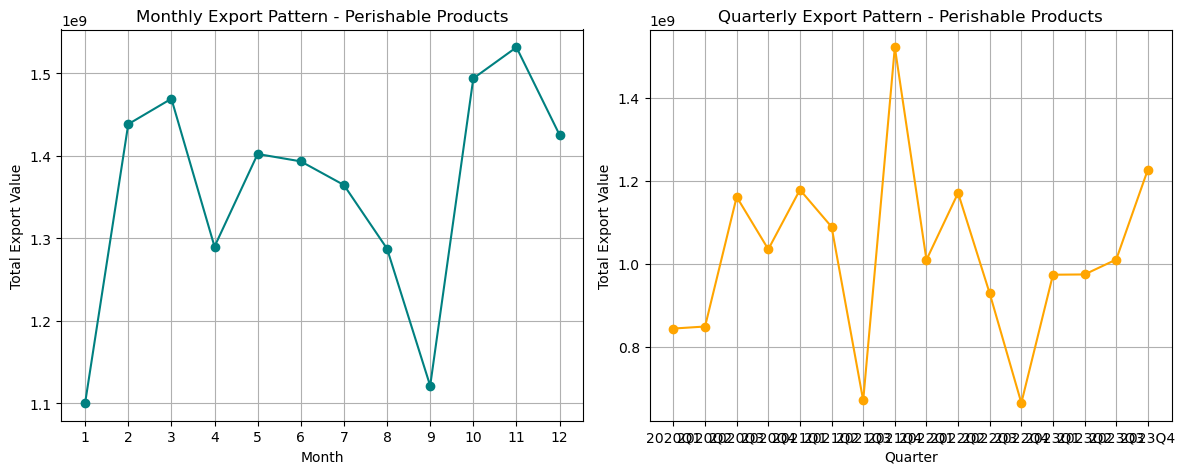

Peak Month: 11 | Product: Palm Oil | Export Value: 306591379.0
Peak Quarter: 2023Q4 | Product: Cassava | Export Value: 263570787.48


In [26]:

# 2. Define perishable products (EDIT THIS LIST for your case)
# -----------------------------
perishable_list = [
   'Rubber', 'Palm Oil', 'Cassava', 'Sesame', 'Cashew', 'Ginger', 'Plantain', 'Cocoa'
]

# -----------------------------
# 3. Filter for perishable products
# -----------------------------
df_perishable = df[df['Product Name'].isin(perishable_list)].copy()

if df_perishable.empty:
    raise ValueError("No perishable products found in dataset. Check your perishable_list.")

# -----------------------------
# 4. Ensure Date is datetime & extract month/quarter
# -----------------------------
df_perishable['Date'] = pd.to_datetime(df_perishable['Date'], errors='coerce')
df_perishable['Month'] = df_perishable['Date'].dt.month
df_perishable['Quarter'] = df_perishable['Date'].dt.to_period('Q')

# -----------------------------
# 5. Aggregate export values by product & month/quarter
# -----------------------------
monthly_exports = df_perishable.groupby(['Product Name', 'Month'])['Export Value'].sum().reset_index()
quarterly_exports = df_perishable.groupby(['Product Name', 'Quarter'])['Export Value'].sum().reset_index()

# -----------------------------
# 6. Plot monthly pattern (all perishable products combined)
# -----------------------------
combined_monthly = df_perishable.groupby('Month')['Export Value'].sum().reset_index()
combined_quarterly = df_perishable.groupby('Quarter')['Export Value'].sum().reset_index()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(combined_monthly['Month'], combined_monthly['Export Value'], marker='o', color='teal')
plt.xticks(range(1, 13))
plt.xlabel("Month")
plt.ylabel("Total Export Value")
plt.title("Monthly Export Pattern - Perishable Products")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(combined_quarterly['Quarter'].astype(str), combined_quarterly['Export Value'], marker='o', color='orange')
plt.xlabel("Quarter")
plt.ylabel("Total Export Value")
plt.title("Quarterly Export Pattern - Perishable Products")
plt.grid(True)

plt.tight_layout()
plt.show()

# -----------------------------
# 7. Find peak month & quarter (with product name)
# -----------------------------
top_month = monthly_exports.loc[monthly_exports['Export Value'].idxmax()]
top_quarter = quarterly_exports.loc[quarterly_exports['Export Value'].idxmax()]

print(f"Peak Month: {top_month['Month']} | Product: {top_month['Product Name']} | Export Value: {top_month['Export Value']}")
print(f"Peak Quarter: {top_quarter['Quarter']} | Product: {top_quarter['Product Name']} | Export Value: {top_quarter['Export Value']}")


Yearly share of total export revenue from top 3 products:
   Year  Total Export Value  Top3 Export Value  Top3 Share (%)  \
0  2020        3.891727e+09       1.701779e+09       43.728112   
1  2021        4.461998e+09       1.849897e+09       41.458941   
2  2022        3.776169e+09       1.656199e+09       43.859234   
3  2023        4.187771e+09       1.902355e+09       45.426442   

             Top 3 Products  
0  Cashew, Palm Oil, Sesame  
1    Cashew, Rubber, Sesame  
2     Cocoa, Rubber, Sesame  
3   Cocoa, Plantain, Sesame  


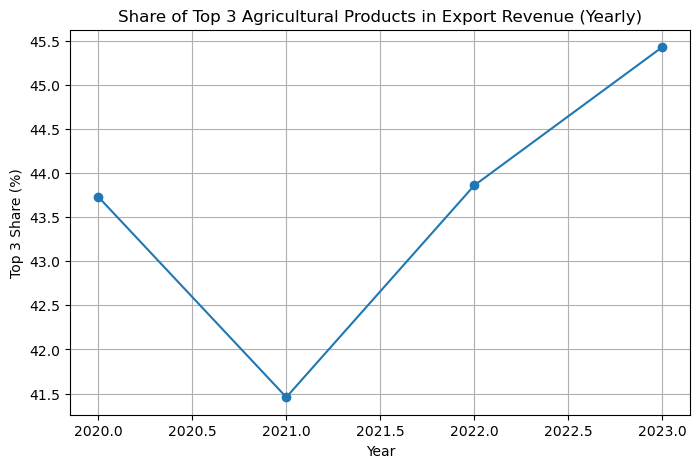

In [25]:

# 3. Aggregate export values per product per year
# -----------------------------
yearly_exports = df.groupby(['Year', 'Product Name'])['Export Value'].sum().reset_index()

# -----------------------------
# 4. Rank products within each year by export value
# -----------------------------
yearly_exports['Rank'] = yearly_exports.groupby('Year')['Export Value'] \
                                       .rank(method='first', ascending=False)

# -----------------------------
# 5. Filter top 3 products each year
# -----------------------------
top3_per_year = yearly_exports[yearly_exports['Rank'] <= 3]

# -----------------------------
# 6. Calculate total export per year and share of top 3
# -----------------------------
total_per_year = yearly_exports.groupby('Year')['Export Value'].sum().reset_index(name='Total Export Value')
top3_sum_per_year = top3_per_year.groupby('Year')['Export Value'].sum().reset_index(name='Top3 Export Value')

# Merge totals and calculate share
share_df = pd.merge(total_per_year, top3_sum_per_year, on='Year')
share_df['Top3 Share (%)'] = (share_df['Top3 Export Value'] / share_df['Total Export Value']) * 100

# -----------------------------
# 7. Add top 3 product names to the result
# -----------------------------
top_products_list = top3_per_year.groupby('Year')['Product Name'].apply(lambda x: ', '.join(x)).reset_index(name='Top 3 Products')
share_df = pd.merge(share_df, top_products_list, on='Year')

# -----------------------------
# 8. Output result
# -----------------------------
print("Yearly share of total export revenue from top 3 products:")
print(share_df)

# -----------------------------
# 9. Plot change over time
# -----------------------------
plt.figure(figsize=(8, 5))
plt.plot(share_df['Year'], share_df['Top3 Share (%)'], marker='o')
plt.title("Share of Top 3 Agricultural Products in Export Revenue (Yearly)")
plt.xlabel("Year")
plt.ylabel("Top 3 Share (%)")
plt.grid(True)
plt.show()


In [27]:

# -----------------------------
# 3. Aggregate export values per country per year
# -----------------------------
country_yearly = df.groupby(['Export Country', 'Year'])['Export Value'].sum().reset_index()

# -----------------------------
# 4. Calculate variance (or std deviation) across years for each country
# -----------------------------
country_variance = country_yearly.groupby('Export Country')['Export Value'].var().reset_index(name='Yearly Variance')
country_variance['Std Dev'] = country_yearly.groupby('Export Country')['Export Value'].std().values

# -----------------------------
# 5. Find the most consistent country (lowest variance)
# -----------------------------
most_consistent = country_variance.sort_values(by='Yearly Variance', ascending=True).head(1)

print("Most consistent export country (lowest year-to-year variance):")
print(most_consistent)

# -----------------------------
# 6. Optional: Rank all countries by consistency
# -----------------------------
print("\nAll countries ranked by consistency (low to high variance):")
print(country_variance.sort_values(by='Yearly Variance', ascending=True))


Most consistent export country (lowest year-to-year variance):
  Export Country  Yearly Variance       Std Dev
8         Sweden     1.259633e+15  3.549131e+07

All countries ranked by consistency (low to high variance):
  Export Country  Yearly Variance       Std Dev
8         Sweden     1.259633e+15  3.549131e+07
0        Austria     2.027951e+15  4.503277e+07
6    Netherlands     3.192744e+15  5.650437e+07
5          Italy     3.568288e+15  5.973515e+07
9    Switzerland     7.049978e+15  8.396414e+07
3         France     8.531909e+15  9.236833e+07
2        Denmark     9.563737e+15  9.779436e+07
7          Spain     1.020749e+16  1.010321e+08
4        Germany     1.238591e+16  1.112920e+08
1        Belgium     1.387857e+16  1.178073e+08
